In [1]:
import io, os, sys, types

In [2]:
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

In [3]:
from rakuten_common import *
# NB_ECHANTILLONS=40000 # Par défaut tous les échantillons sont utilisés

In [6]:
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, RNN, GRUCell, Dropout, Bidirectional, LSTM, GRU

In [17]:
class Multilingu(RakutenBaseModel):
    """
    Modèle de plongement (embedding) dans un modèle de texte préentrainé
    (Multilingual-large)
    """
    def __init__(self, nb=None):
        super().__init__(self.__class__.__name__, nb)
        self.embedding_length = 512 # Défini par le modèle Multilingual/large
        self.std = StandardScaler()

    def get_model_body(self):
        self.layer_index = 0
        inp = tf.keras.layers.Input(shape=(self.embedding_length,),
                                    name=self.layer_name("input"))
        x = tf.keras.layers.BatchNormalization(name=self.layer_name("batchnorm"))(inp)
#        x = tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True))(x)
        x = tf.keras.layers.Dense(200, activation='swish', name=self.layer_name("dense"))(x)
        x = tf.keras.layers.Dropout(0.2, name=self.layer_name("dropout"))(x)
        x = tf.keras.layers.BatchNormalization(name=self.layer_name("batchnorm"))(x)
        x = tf.keras.layers.Dense(50, activation='swish', name=self.layer_name("dense"))(x)
        x = tf.keras.layers.Dropout(0.4, name=self.layer_name("dropout"))(x)
#        x = tf.keras.layers.Dense(50, activation='swish', name=self.layer_name("dense"))(x)
#        x = tf.keras.layers.Dropout(0.45, name=self.layer_name("dropout"))(x)
        return inp, x

    def preprocess_X_train(self, off_start, off_end, input_file=None):
        X_train = get_X_text_embed_multilingual(input_file)[off_start:off_end]
        X_train = self.std.fit_transform(X_train)
        return X_train

    def preprocess_X_test(self, off_start, off_end, input_file=None):
        X_test = get_X_text_embed_multilingual(input_file)[off_start:off_end]
        X_test = self.std.transform(X_test)
        return X_test

    def fit(self, off_start, off_val, off_end, input_file=None):

        X_train = self.preprocess_X_train(off_start, off_val, input_file)
        y_train = self.preprocess_y_train(off_start, off_val, input_file)

        X_val = self.preprocess_X_test(off_val, off_end, input_file)
        y_val = self.preprocess_y_train(off_val, off_end, input_file)

        self.model = self.get_model()
        
        return self.compile_and_train_gen(X_train, y_train, X_val, y_val, optimizer='adam',
                                         epochs=50, patience_stop=8, patience_lr=3, class_weight=[])

++ [23h31mn] Multilingu: Evaluation avec 84916 échantillons
++ [23h31mn] Multilingu: fit(): Début
Epoch 1/50
1805/1805 [==============================] - 4s 2ms/step - loss: 1.2868 - accuracy: 0.6287 - val_loss: 0.7893 - val_accuracy: 0.7528
Epoch 2/50
1805/1805 [==============================] - 3s 2ms/step - loss: 0.9630 - accuracy: 0.7130 - val_loss: 0.7268 - val_accuracy: 0.7706
Epoch 3/50
1805/1805 [==============================] - 3s 2ms/step - loss: 0.8772 - accuracy: 0.7363 - val_loss: 0.7042 - val_accuracy: 0.7767
Epoch 4/50
1805/1805 [==============================] - 3s 2ms/step - loss: 0.8273 - accuracy: 0.7479 - val_loss: 0.6871 - val_accuracy: 0.7872
Epoch 5/50
1805/1805 [==============================] - 3s 2ms/step - loss: 0.7924 - accuracy: 0.7593 - val_loss: 0.6706 - val_accuracy: 0.7909
Epoch 6/50
1805/1805 [==============================] - 3s 2ms/step - loss: 0.7604 - accuracy: 0.7679 - val_loss: 0.6665 - val_accuracy: 0.7921
Epoch 7/50
1805/1805 [================

C:\Users\utilisateur\Documents\projet_rakuten\rakuten_common.py:271: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(history.history[s], 'bo', color='orange')
C:\Users\utilisateur\Documents\projet_rakuten\rakuten_common.py:272: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(history.history['val_' + s], 'b', color='blue')


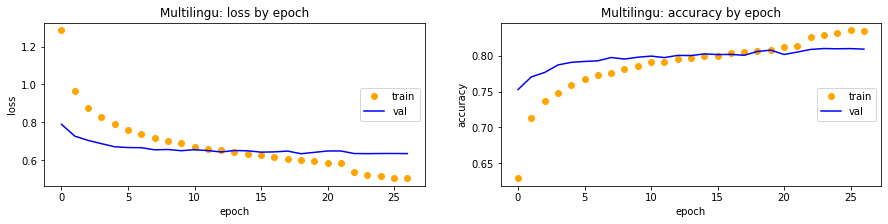

++ [23h33mn] Multilingu: fit(): Fin

++ [23h33mn] Multilingu: predict(): Début
531/531 [==============================] - 0s 599us/step
++ [23h33mn] Multilingu: predict(): Fin

++ [23h33mn] Multilingu: w-f1-score = 0.797

              precision    recall  f1-score   support

          10       0.57      0.65      0.61       652
        1140       0.72      0.74      0.73       541
        1160       0.88      0.94      0.91       815
        1180       0.61      0.58      0.60       140
        1280       0.65      0.58      0.61       956
        1281       0.67      0.46      0.55       399
        1300       0.82      0.94      0.88      1051
        1301       0.90      0.86      0.88       168
        1302       0.73      0.72      0.73       497
        1320       0.73      0.74      0.73       683
        1560       0.79      0.76      0.77       993
        1920       0.84      0.90      0.87       841
        1940       0.84      0.94      0.88       147
        2060       0.

In [18]:
Multilingu().evaluate(NB_ECHANTILLONS)

In [8]:
import tensorflow as tf


In [9]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [10]:
class NPDataset(tf.keras.utils.Sequence):
    """
    Générateur qui extrait les données (de type tableau numpy)
    à partir d'un path de fichier
    """
    def __init__(self, batch_size,
                 X, y=None, shuffle=False, random_state=1968):
        nb = len(X)
        self.y = y
        self.batch_size = batch_size
        self.batch_number = int(nb / batch_size)
        self.batch_indexes = range(self.batch_number)
        self.prefix = re.match(r'^(.*)_\d+\.npy$', X[0]).group(1)
        if shuffle:
            self.random_state = random_state
            self.batch_indexes = sklearn.utils.shuffle(self.batch_indexes,
                                                       random_state=random_state)
        self.shuffle = shuffle

    def __len__(self):
        """ Retourne le nombre de batchs """
        return self.batch_number

    def __getitem__(self, index):
        index = self.batch_indexes[index]
        X = []
        for i in range(index*self.batch_size, (index+1)*self.batch_size):
            f = f"{self.prefix}_{i}.npy"
            with open(f, 'rb') as fd:
                x = np.load(fd)
                X.append(x)
        X = np.array(X)
        if self.y is None:
            return X
        else:
            y = self.y[index*self.batch_size : (index+1)*self.batch_size]
            return X, y

    def on_epoch_end(self):
        """ Changements effectués à chaque fin d'époque """
        if self.shuffle:
            self.batch_indexes = sklearn.utils.shuffle(self.batch_indexes,
                                                       random_state=self.random_state)
        

class TextOneHot(RakutenBaseModel):
    """
    Modèle NN exécuté après un préprocessing des données effectué
    avec un pipe sklearn <TfidfVectorizer | SelectFromModel(LinearSVC)>
    """
    def __init__(self, nb=None):
        super().__init__(self.__class__.__name__, nb)
        self.maxfeatures = 200000 # Nombre de features selectionnées par SVC
        self.select = make_pipeline(
            TfidfVectorizer(analyzer='word',
                  #strip_accents='ascii',
                  #stop_words=french_stop_words, 
                  #    tokenizer=tokenize_spacy, # les données sont déjà tokenizées
                  preprocessor=' '.join,
                  lowercase=False,
                  stop_words=None,
                  max_df=0.8,
                  min_df=2,
                  ngram_range=(1,2),
                  use_idf=True,
                  smooth_idf=True,
                  sublinear_tf=False,
                  binary=True,
 #                 max_features=30000,  moins rentable que celui de SelectFromModel 
                  ),
                  SelectFromModel(LinearSVC(penalty="l2", dual=True, C=0.8,
                                            tol=1e-5, max_iter=4000),
                                  max_features=self.maxfeatures))

    def __flush_data_to_file(self, data, tag, off_start, off_end, input_file=None):
        filelist = []
        for i in range(data.shape[0]):
            f = os.path.join(OUTDIR, f"{self.name}_{tag}_{off_start}_{off_end}_{i}.npy")
            with open(f, 'wb') as fd:
                datum = data[i].toarray()[0]
                #print(type(datum), datum.shape)
                np.save(fd, datum)
            filelist.append(f)
        return filelist
    
    def data_from_file(self, filepath):
        """
        Méthode pour lire une donnée preprocessée à partir d'un fichier
        et la retourner
        """
        with open(filepath, 'rb') as fd:
            datum = np.load(fd)
        return datum

    def get_model_body(self):
        self.layer_index = 0
        inp = tf.keras.layers.Input(shape=self.input_shape, name=self.layer_name("input"))
        x = inp
#        x = tf.keras.layers.Dense(90, activation='relu', name=self.layer_name("dense"))(inp)
#        x = tf.keras.layers.Dropout(0.5, name=self.layer_name("dropout"))(x)
        x = tf.keras.layers.BatchNormalization(name=self.layer_name("batchnorm"))(x)
        return inp, x

    def preprocess_X_train(self, off_start, off_end, input_file=None):
        y_train = get_y()[off_start:off_end]
#        X_train = get_X_text(input_file)[off_start:off_end]
        X_train = get_X_text_spacy_lemma(input_file)[off_start:off_end]
        X_train = self.select.fit_transform(X_train, y_train)
        self.input_shape = X_train.shape[1:]
        self.prt(f"Nombre de mots retenus = {self.input_shape[0]}")
        return self.__flush_data_to_file(X_train, "train", off_start, off_end)

    def preprocess_X_test(self, off_start, off_end, input_file=None):
#        X_test = get_X_text(input_file)[off_start:off_end]
        X_test = get_X_text_spacy_lemma(input_file)[off_start:off_end]
        X_test = self.select.transform(X_test)
        return self.__flush_data_to_file(X_test, "test", off_start, off_end)

    def fit(self, off_start, off_val, off_end, input_file=None):

        X_train = self.preprocess_X_train(off_start, off_val, input_file)
        y_train = self.preprocess_y_train(off_start, off_val, input_file)
        trainds = NPDataset(self.batch_size, X_train, y_train, shuffle=True)

        X_val = self.preprocess_X_test(off_val, off_end, input_file)
        y_val = self.preprocess_y_train(off_val, off_end, input_file)
        valds = NPDataset(self.batch_size, X_val, y_val, shuffle=True)

        self.model = self.get_model()

        return self.compile_and_train_dataset(trainds, valds,
                                              optimizer=tf.keras.optimizers.Adam(lr=0.0002),
                                              epochs=50,
                                              patience_stop=7, patience_lr=4)

    def predict(self, off_start, off_end, input_file=None):
        X_test = self.preprocess_X_test(off_start, off_end, input_file)
        testds = NPDataset(1, X_test, shuffle=False)
        return self.model_predict(testds)

++ [21h24mn] TextOneHot: Evaluation avec 84916 échantillons
++ [21h25mn] TextOneHot: Nombre de mots retenus = 123332


C:\Users\utilisateur\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


++ [21h32mn] TextOneHot: fit(): Début
Epoch 1/50
1804/1804 [==============================] - 221s 122ms/step - loss: 1.5091 - accuracy: 0.6449 - val_loss: 0.7260 - val_accuracy: 0.8063
Epoch 2/50
1804/1804 [==============================] - 221s 122ms/step - loss: 0.6275 - accuracy: 0.8698 - val_loss: 0.5645 - val_accuracy: 0.8335
Epoch 3/50
1804/1804 [==============================] - 220s 122ms/step - loss: 0.3823 - accuracy: 0.9273 - val_loss: 0.5319 - val_accuracy: 0.8394
Epoch 4/50
1804/1804 [==============================] - 219s 122ms/step - loss: 0.2593 - accuracy: 0.9544 - val_loss: 0.5316 - val_accuracy: 0.8393
Epoch 5/50
1804/1804 [==============================] - 220s 122ms/step - loss: 0.1837 - accuracy: 0.9713 - val_loss: 0.5417 - val_accuracy: 0.8473
Epoch 6/50
1804/1804 [==============================] - 218s 121ms/step - loss: 0.1320 - accuracy: 0.9814 - val_loss: 0.5589 - val_accuracy: 0.8480
Epoch 7/50
1804/1804 [==============================] - 219s 121ms/step - 

C:\Users\utilisateur\Documents\projet_rakuten\rakuten_common.py:271: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(history.history[s], 'bo', color='orange')
C:\Users\utilisateur\Documents\projet_rakuten\rakuten_common.py:272: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(history.history['val_' + s], 'b', color='blue')


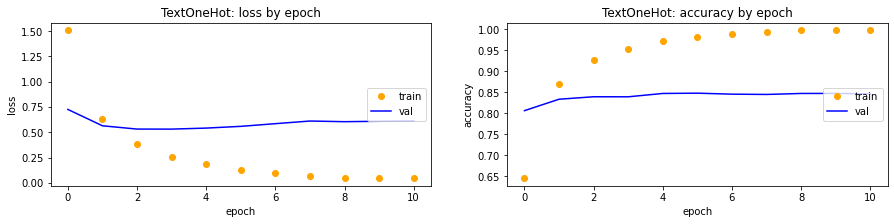

++ [22h13mn] TextOneHot: fit(): Fin



OSError: 123332 requested and 0 written

In [9]:
TextOneHot().evaluate(NB_ECHANTILLONS)

In [6]:
class EffNet(RakutenBaseModel):                                                 #! Nom de la classe
    """
    Modèle de transfert learning d'images avec EfficientNet et l'utilisation
    d'un générateur d'images augmentées.
    https://www.dlology.com/blog/transfer-learning-with-efficientnet/
    """

    def __init__(self, nb=None):
        super().__init__(self.__class__.__name__, nb)
        self.input_shape = (240, 240, 3) # Dépend du numéro x (EfficientNetBx)  #! Shape
        self.preprocessing_function = None # Inclus dans le modèle              #! Preprocessor
        self.basetrainable = 16
        self.epochs_freezed = 10
        self.epochs_unfreezed = 10
        self.batch_size = 32

    def preprocess_X_train(self, off_start, off_end, input_file=None):
        return get_X_image_path(input_file)[off_start:off_end]

    def preprocess_X_test(self, off_start, off_end, input_file=None):
        return get_X_image_path(input_file)[off_start:off_end]
    
    def data_from_file(self, filepath):
        """
        Méthode pour lire une image à partir d'un fichier et la retourner
        au bon format (adapté aux entrées du modèle modèle)
        """
        img = cv2.imread(filepath)
        img = cv2.resize(img, (240, 240), interpolation=cv2.INTER_CUBIC)        #! Shape
        return img

    def get_model_body(self):
        self.layer_index = 0
        self.basemodel = tf.keras.applications.EfficientNetB1(                  #!
                                input_shape = self.input_shape,                 #!
                                include_top = False,                            #! Modèle
                                # drop_connect_rate=0.4,                        #!
                                weights = 'imagenet')                           #!
        inp = Input(shape=self.input_shape, name="input_" + self.name)
        x = self.basemodel(inp)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(1024, activation="relu", name=self.layer_name("dense"))(x)
        x = tf.keras.layers.BatchNormalization(trainable = True,axis=1, name=self.layer_name("batchnorm"))(x)
        x = tf.keras.layers.Dropout(0.5, name=self.layer_name("dropout"))(x)
        x = tf.keras.layers.Dense(512, activation="relu", name=self.layer_name("dense"))(x)
        x = tf.keras.layers.BatchNormalization(trainable = True, axis=1, name=self.layer_name("batchnorm"))(x)
        return inp, x

    def __get_train_dataset(self, X_imagepaths, y_train):
        df = pd.DataFrame({"imgpath": X_imagepaths, "class": y_train})
        datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
                                    validation_split = VALIDATION_SPLIT,
                                    preprocessing_function = self.preprocessing_function,
                                    rotation_range = 10,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    zoom_range = 0.1,
                                    brightness_range=[0.9, 1.1],
                                    horizontal_flip = True
                                    )
        traingen = datagenerator.flow_from_dataframe(subset = 'training', dataframe=df,
                                                     x_col="imgpath", y_col="class",
                                                     class_mode="sparse",
                                                     target_size=(self.input_shape[0], self.input_shape[1]),
                                                     batch_size=self.batch_size)
        valgen = datagenerator.flow_from_dataframe(subset='validation',
                                                   dataframe=df, x_col="imgpath", y_col="class",
                                                   class_mode="sparse",
                                                   target_size=(self.input_shape[0], self.input_shape[1]),
                                                   batch_size=self.batch_size)
        return traingen, valgen

    def __get_test_dataset(self, X_imagepaths):
        df = pd.DataFrame({"imgpath": X_imagepaths,
                           "class": [0 for _ in range(len(X_imagepaths))]})
        testgen = tf.keras.preprocessing.image.ImageDataGenerator( 
                        preprocessing_function = self.preprocessing_function).flow_from_dataframe(
                        dataframe=df, x_col="imgpath", y_col="class",
                        class_mode=None, target_size=(self.input_shape[0], self.input_shape[1]),
                        batch_size=1,
                        shuffle = False)
        return testgen

    def fit(self, off_start, off_val, off_end, input_file=None):

        self.prt(f"Création des générateurs d'images")
        X_imgpaths = get_X_image_path(input_file)[off_start:off_end]
        y_train = get_y()[off_start:off_end]
        traingen, valgen = self.__get_train_dataset(X_imgpaths, y_train)
        self.fit_labels = dict((v,k) for k,v in (traingen.class_indices).items())

        self.model = self.get_model()
        
        self.prt(f"Congélation des layers du modèle de base et entrainement")
        for layer in self.basemodel.layers:
            layer.trainable = False
        history = self.compile_and_train_dataset(traingen, valgen,
                                         optimizer=tf.keras.optimizers.Adam(lr=1e-3),
                                         epochs=self.epochs_freezed)
        if self.basetrainable > 0:
            self.prt(f"Décongélation des {self.basetrainable} derniers layers et entrainement")
            for layer in self.basemodel.layers[-self.basetrainable:]:
                if not isinstance(layer, tf.keras.layers.BatchNormalization):
                    layer.trainable = True
            self.compile_and_train_dataset(traingen, valgen,
                                   optimizer=tf.keras.optimizers.Adam(lr=1e-4),
                                   epochs=self.epochs_unfreezed)
        self.prt("Entrainement terminé")
        return history

    def predict(self, off_start, off_end, input_file=None):
        X_test = self.preprocess_X_test(off_start, off_end, input_file)
        testgen = self.__get_test_dataset(X_test)
        return self.model_predict(testgen)

In [7]:
EffNet().evaluate(NB_ECHANTILLONS)                                   #! Execution pour la classe

++ [22h42mn] EffNet: Evaluation avec 84916 échantillons
++ [22h42mn] EffNet: Création des générateurs d'images


TypeError: All values in column x_col=imgpath must be strings.

In [11]:
class CatModel(RakutenCatModel):
    """
    Modèle qui concatene plusieurs modèles de base
    """
    def __init__(self, nb=None):
        super().__init__(self.__class__.__name__, nb)
        
    def fit(self, off_start, off_val, off_end, input_file=None):
        """
        Entrainement du modèle sur l'intervalle des données spécifié par
        off_start et off_end (offsets dans les fichiers de data).
        """

        self.prt(f'Chargements des modèles référencés "{self.nb}"')
        self.objs = [
             TextOneHot(self.nb),
             Multilingu(self.nb),
             EffNet(self.nb)
        ]

        # Générateurs qui alimenteront fit() avec les données train & val
        traingen, valgen = self.create_train_generators(off_start, off_val, off_end, input_file)
        
        self.prt(f"Création du modèle")
        # Récupèration des inputs et des outputs de chaque modèle de base
        # pour construire le modèle concatenate
        inputlayers, outputlayers = [], []
        for obj in self.objs:
            inp, outp = obj.get_model_body()
            inputlayers.append(inp)
            outputlayers.append(outp)
        
        self.layer_index = 0 # compteur utilisé dans get_model_body()
        concatname = self.layer_name("concatenate")
        x = concatenate(outputlayers, axis=-1, name = concatname)
        x = Dense(64, activation='relu', name=self.layer_name("dense"))(x)
        x = Dropout(0.3, name=self.layer_name("dropout"))(x)
        x = Dense(NB_CLASSES, activation='softmax', name=self.layer_name("dense"))(x)
        self.model = Model(inputlayers, x, name=self.name)

        #print(self.model.summary())

        print(f"  * Layers non entrainables:")
        for layer in self.model.layers[:-3]:
            layer.trainable = False
            print(f"      - {layer.name}")
        print(f"  * Layers entrainables:")
        for layer in self.model.layers:
            if layer.trainable:
                print(f"      - {layer.name}")

        self.model.compile(optimizer= tf.keras.optimizers.Adam(lr=1e-3),
                           loss='sparse_categorical_crossentropy',
                           metrics = ['accuracy'])

        # Initialisation des poids
        self.copy_submodels_weights()

        self.prt("fit(): Début")    
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,
                                             restore_best_weights=True, verbose=1),
                     tf.keras.callbacks.ModelCheckpoint(filepath=self.fbestweights,
                                             save_weights_only=True, save_best_only=True,
                                              monitor='val_loss', mode='min'),
                     tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.1,
                                                          verbose=1)]
        if os.path.isfile(self.fbestweights):
            os.remove(self.fbestweights)
        history = self.model.fit(traingen,
                                 epochs=12,
                                 validation_data = valgen,
                                 callbacks=callbacks)
        if os.path.isfile(self.fbestweights):
            self.model.load_weights(self.fbestweights)
        self.prt("fit(): Fin")
        plot_history(f"{self.name}", history)
        return history

In [12]:
CatModel().evaluate(NB_ECHANTILLONS)

++ [21h39mn] CatModel: Evaluation avec 84916 échantillons
++ [21h39mn] CatModel: Chargements des modèles référencés "84916"


ValueError: Pas de fichier modele_rakuten_out\TextOneHot_84916_object.pkl